
# Get GOES  
### Generating a Machine Learning Ready Dataset from GOES Imagery  
---

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/reykoki/Get_GOES/blob/main/Get_GOES.ipynb)

![](https://cdn.star.nesdis.noaa.gov/GOES16/ABI/CONUS/DayNightCloudMicroCombo/GOES16-CONUS-DayNightCloudMicroCombo-625x375.gif)

**Notebook Author:** Rey Koki · rey.koki@noaa.gov  
**Affiliations:**  
1. Cooperative Institute for Research in Environmental Sciences ([CIRES](https://cires.colorado.edu/))  
2. NOAA Global Systems Laboratory ([GSL](https://gsl.noaa.gov/))  

**Acknowledgements:**  
Funding support for this notebook was provided by NOAA's National Centers for Environmental Information (NCEI).

---

### Overview

**Get GOES** is the starting point in a [two-part tutorial series](https://github.com/reykoki/Smoke_Semantic_Segmenation_Learning_Notebook/tree/main) on using GOES satellite imagery for a deep learning smoke detection application. This is **Notebook 0 of 2** and is designed to stand on its own. It focuses on downloading, processing, and visualizing GOES data, with no prior experience in machine learning required.

In this notebook, users will learn how to project GOES imagery, generate different composite views such as True Color, and plot data from any of the 16 GOES bands. These skills are valuable for a wide range of remote sensing applications.

Even if you're not planning to train a model, this notebook is a practical guide to working with NOAA's GOES imagery using open-source tools. If you are preparing data for a machine learning pipeline, this notebook provides the foundation you'll need to create a machine learning ready GOES dataset. Users will still need to supply labels, as demonstrated in the [SmokeViz Dataset Learning Notebook](https://github.com/reykoki/Smoke_Semantic_Segmenation_Learning_Notebook/blob/main/SmokeViz_Chapter_1_Dataset.ipynb).


#### Machine Learning GOES Data
This notebook provides a starting point for building custom machine learning dataset from GOES imagery. By specifying a latitude, longitude, and spatial extent, you can extract a localized subset of satellite data. The output is a machine learning–ready `.tif` image, ideal for building labeled datasets tailored to your specific research or application.

#### Example GOES Machine Learning Applications
1. Fire Hotspot Detection
2. Burn Scar Mapping
3. Contrail Detection
4. Cloud Phase Classification
5. Hurricane Eye Tracking
6. Land Use Change

---

### Prerequisites

This notebook is designed for users with basic experience in Python and an interest in working with satellite imagery. To get the most out of this tutorial, you should be comfortable with:

- Running Python code in a Jupyter or Colab notebook  
- Basic Python libraries like `numpy` and `matplotlib`
- Introductory geospatial concepts (e.g., map projections)  
- Familiarity with satellite data formats such as NetCDF or HDF is helpful, but not required  

We recommend reviewing the following resources before or alongside this notebook:

#### Background on GOES Data
- [GOES-R Series Overview (NOAA)](https://www.goes-r.gov/)  
- [GOES-R ABI Band Guide (NOAA)](https://www.goes-r.gov/education/ABI-bands-quick-info.html)  
- [NOAA Open Data on AWS – GOES](https://registry.opendata.aws/noaa-goes/)

#### Tools Used in This Notebook
- [SatPy Documentation](https://satpy.readthedocs.io/en/stable/)  used for reading, compositing, and projecting GOES imagery    
- [matplotlib Documentation](https://matplotlib.org/stable/contents.html)  for plotting and visualization

#### Related Notebooks
- [SmokeViz Dataset Learning Notebook](https://github.com/reykoki/Smoke_Semantic_Segmenation_Learning_Notebook/blob/main/SmokeViz_Chapter_1_Dataset.ipynb) follow-up to this notebook for applying machine learning to smoke detection

### Learning Outcomes

By the end of this tutorial, you will be able to:

1. Download [GOES satellite imagery from AWS](https://registry.opendata.aws/noaa-goes/) for a specified date and time  
2. Use SatPy to reproject GOES imagery and generate True Color composites for the Continental U.S. (CONUS)  
3. Visualize CONUS True Color imagery 
4. Extract and crop localized image subsets for regions of interest, formatted for machine learning workflows  
5. Plot individual GOES bands and composite products in their machine learning ready format

Time Estimate

* Estimated text reading time: 10 to 20 min
* Estimated code reading time: 10 to 20 min
* Estimated total reading time: 20 to 40 min



In [6]:
import os
if os.getcwd() == '/content':
    print("You are working in a Google colab notebook!\nLet's grab data and code from github.\n")
    !rm -r Get_GOES scripts figures data
    !git clone https://github.com/reykoki/Get_GOES.git
    !rm Get_GOES/Get_GOES.ipynb
    !mv Get_GOES/* .
    !pip install -r requirements.txt
import matplotlib.pyplot as plt
import numpy as np
import sys
sys.path.insert(1, './scripts')
from helper_functions import *

## 1. GOES Satellite Imagery

In this notebook, we work with imagery from the GOES-East Advanced Baseline Imager (ABI) and demonstrate how to generate a geographically localized data sample based on a given latitude and longitude.

For a comprehensive technical overview of the GOES satellite system and its instruments, see the [GOES-R Series Data Book](https://www.goes-r.gov/downloads/resources/documents/GOES-RSeriesDataBook.pdf).


![GOES-16](https://cdn.star.nesdis.noaa.gov/GOES16/ABI/CONUS/GEOCOLOR/GOES16-CONUS-GEOCOLOR-625x375.gif "GOES")


Satellite remote sensors detect reflected or emitted radiation in specific spectral bands, also known as channels. Each band is sensitive to a particular range of wavelengths and is best suited for highlighting certain features or atmospheric conditions.

The ABI instrument onboard GOES satellites collects data across 16 spectral bands, covering the visible (C01–C02), near-infrared (C03–C06), and infrared (C07–C16) regions.



| Band | Description | Center Wavelength ($\mu$m) | Spatial Resolution (km) |
| :-: | :- | :-: | :-: |
| [C01](https://cimss.ssec.wisc.edu/goes/OCLOFactSheetPDFs/ABIQuickGuide_Band01.pdf) | Blue visible | 0.47 | 1 |
| [C02](https://cimss.ssec.wisc.edu/goes/OCLOFactSheetPDFs/ABIQuickGuide_Band02.pdf) | Red visible | 0.64 | 0.5 |
| [C03](https://cimss.ssec.wisc.edu/goes/OCLOFactSheetPDFs/ABIQuickGuide_Band03.pdf) | Veggie near-IR | 0.865 | 1 |
| [C04](https://cimss.ssec.wisc.edu/goes/OCLOFactSheetPDFs/ABIQuickGuide_Band04.pdf) | Cirrus detection | 1.378 | 2 |
| [C05](https://cimss.ssec.wisc.edu/goes/OCLOFactSheetPDFs/ABIQuickGuide_Band05.pdf) | Snow/Ice discrimination | 1.61 | 1 |
| [C06](https://cimss.ssec.wisc.edu/goes/OCLOFactSheetPDFs/ABIQuickGuide_Band06.pdf) | Cloud particle size | 2.24 | 2 |
| [C07](https://cimss.ssec.wisc.edu/goes/OCLOFactSheetPDFs/ABIQuickGuide_Band07.pdf) | Shortwave IR | 3.9 | 2 |
| [C08](https://cimss.ssec.wisc.edu/goes/OCLOFactSheetPDFs/ABIQuickGuide_Band08.pdf) | Upper-level water vapor | 6.2 | 2 |
| [C09](https://cimss.ssec.wisc.edu/goes/OCLOFactSheetPDFs/ABIQuickGuide_Band09.pdf) | Mid-level water vapor | 6.9 | 2 |
| [C10](https://cimss.ssec.wisc.edu/goes/OCLOFactSheetPDFs/ABIQuickGuide_Band10.pdf) | Lower-level water vapor | 7.3 | 2 |
| [C11](https://cimss.ssec.wisc.edu/goes/OCLOFactSheetPDFs/ABIQuickGuide_Band11.pdf) | Cloud phase (IR) | 8.5 | 2 |
| [C12](https://cimss.ssec.wisc.edu/goes/OCLOFactSheetPDFs/ABIQuickGuide_Band12.pdf) | Ozone | 9.6 | 2 |
| [C13](https://cimss.ssec.wisc.edu/goes/OCLOFactSheetPDFs/ABIQuickGuide_Band13.pdf) | Clean longwave IR | 10.35 | 2 |
| [C14](https://cimss.ssec.wisc.edu/goes/OCLOFactSheetPDFs/ABIQuickGuide_Band14.pdf) | Standard longwave IR | 11.2 | 2 |
| [C15](https://cimss.ssec.wisc.edu/goes/OCLOFactSheetPDFs/ABIQuickGuide_Band15.pdf) | Dirty longwave IR | 12.3 | 2 |
| [C16](https://cimss.ssec.wisc.edu/goes/OCLOFactSheetPDFs/ABIQuickGuide_Band16.pdf) | CO$_2$ absorption | 13.3 | 2 |

New ABI-L1b-RadC data files are produced every 5 minutes by both GOES-East and GOES-West. These files are distributed in NetCDF4 format and include calibrated radiance data for each spectral band.

---

## 1.1. Download GOES NetCDF Files

We begin by downloading the 16-band ABI L1b radiance files for a given datetime from the [NOAA GOES dataset on AWS](https://registry.opendata.aws/noaa-goes/).

### 1.1.1. Define the Target Date and Time

Use the format `YYYY/mm/dd HH:MM` to specify the datetime for which you want to retrieve imagery.

In [31]:
from datetime import datetime
import pytz

# Define the target datetime as a string in the format YYYY/MM/DD HH:MM
dt_str = '2022/06/04 00:56'

# Convert the string to a naive datetime object, then localize it to UTC
dt = pytz.utc.localize(datetime.strptime(dt_str, '%Y/%m/%d %H:%M'))

# Print the resulting UTC datetime
print(dt)

2022-06-04 00:56:00+00:00


### 1.1.2. Download Files from AWS

We use the Python interface to [s3fs](https://github.com/fsspec/s3fs) to access GOES imagery stored in NOAA’s public S3 bucket on AWS.  
For implementation details, see the helper functions provided in `./scripts/grab_goes.py`.

To help select a valid daytime image, the notebook prints the estimated sunrise time (UTC) on the U.S. West Coast and sunset time on the East Coast for the given date.  
Choosing a UTC time between those two bounds ensures that there is sunlight somewhere over CONUS, which is important when working with visible or True Color imagery.

In [8]:
# Import the main GOES data download script
from grab_goes import download_goes  # located at ./scripts/grab_goes.py

# Call the download function with the target datetime (dt)
# This function handles locating, accessing, and downloading the full set of GOES ABI band files
sat_fns = download_goes(dt)  # Returns a list of downloaded NetCDF file paths

for the datetime 2022-06-04 00:56:00+00:00:
sunrise is at: 2022-06-04 13:30:00+00:00
sunset is at: 2022-06-04 00:29:00+00:00
OR_ABI-L1b-RadC-M6C01_G16_s20221550056176_e20221550058549_c20221550058590.nc already exists
OR_ABI-L1b-RadC-M6C02_G16_s20221550056176_e20221550058549_c20221550058571.nc already exists
OR_ABI-L1b-RadC-M6C03_G16_s20221550056176_e20221550058549_c20221550058597.nc already exists
OR_ABI-L1b-RadC-M6C04_G16_s20221550056176_e20221550058549_c20221550058577.nc already exists
OR_ABI-L1b-RadC-M6C05_G16_s20221550056176_e20221550058549_c20221550058583.nc already exists
OR_ABI-L1b-RadC-M6C06_G16_s20221550056176_e20221550058554_c20221550058587.nc already exists
OR_ABI-L1b-RadC-M6C07_G16_s20221550056176_e20221550058560_c20221550058595.nc already exists
OR_ABI-L1b-RadC-M6C08_G16_s20221550056176_e20221550058549_c20221550059006.nc already exists
OR_ABI-L1b-RadC-M6C09_G16_s20221550056176_e20221550058554_c20221550059009.nc already exists
OR_ABI-L1b-RadC-M6C10_G16_s20221550056176_e2022

## 2. True Color GOES Imagery for CONUS

In this section, we visualize GOES ABI data using the C01, C02 and C03 bands from the ABI Level 1b CONUS (ABI-L1b-RadC) product to create a true color image.

We demonstrate how to use the [satpy](https://satpy.readthedocs.io/en/latest/) library to read and augment our satellite data as seen in the image below.

![](https://raw.githubusercontent.com/reykoki/Get_GOES/main/figures/processing.png)

### 2.2. True Color Composite

To generate a realistic visualization of the Earth's surface, we apply a series of corrections to produce the CIMSS True Color composite from GOES ABI data. This approach simulates what the human eye would perceive using a blend of visible and near-infrared channels.

For more details, see the CIMSS True Color [research paper](https://agupubs.onlinelibrary.wiley.com/doi/10.1029/2018EA000379) and the [quick guide](https://cimss.ssec.wisc.edu/goes/OCLOFactSheetPDFs/ABIQuickGuide_CIMSSRGB_v2.pdf). A full list of available composites supported by the SatPy library for the ABI instrument can be found [here](https://github.com/pytroll/satpy/blob/main/satpy/etc/composites/abi.yaml).

The CIMSS True Color composite applies the following key corrections:

- **True color approximation** – combines channels C01 (blue), C02 (red), and C03 (near-IR) to estimate a green channel and produce a full RGB image that resembles natural color.
- **Solar zenith angle correction** – accounts for lighting geometry and the amount of atmosphere sunlight must pass through, which affects brightness and color.
- **Rayleigh scattering correction** - adjusts for the wavelength-dependent scattering of sunlight by air molecules and small particles in the atmosphere, improving color balance and visibility.



In [9]:
# define the true color composite
composite = ['cimss_true_color_sunz_rayleigh'] 

### 2.3. Lambert Conformal Conic Projection

To reduce distortion introduced by the native geostationary azimuthal projection of GOES imagery, we reproject the data onto a [Lambert Conformal Conic (LCC) projection](https://en.wikipedia.org/wiki/Lambert_conformal_conic_projection).

The LCC projection is commonly used for mid-latitude regions like the continental United States, as it preserves shape and minimizes distortion across large east–west extents. For reference, the original GOES projection is described in the [geostationary azimuthal projection documentation](https://proj.org/en/9.2/operations/projections/geos.html).


In [10]:
import cartopy.crs as ccrs
# Define a function to return a Lambert Conformal Conic (LCC) projection
def get_proj():
    lcc_proj = ccrs.LambertConformal(
        central_longitude=262.5,        # Centered roughly on central CONUS
        central_latitude=38.5,          # Standard parallel and projection center latitude
        standard_parallels=(38.5, 38.5),# True at 38.5°N; reduces distortion near this latitude
        globe=ccrs.Globe(               # Define Earth shape with spherical approximation
            semimajor_axis=6371229,
            semiminor_axis=6371229     # Use spherical Earth model (radius in meters)
        )
    )
    return lcc_proj

# Define the extent of the projected image in meters [x_min, x_max, y_min, y_max]
# Covers the Continental U.S. in the Lambert Conformal projection
extent = [-2.4e6, -1.5e6, 2.3e6, 1.4e6]

### 2.4. Load Data into a Satpy Scene Object

Once the satellite data has been downloaded locally, we use Satpy to load it into a `Scene` object, which provides a high-level interface for working with multi-band satellite imagery.

We also define the projection and spatial extent using the `create_area_def` function from the `pyresample` library. This defines the output grid and coordinate reference system for reprojection and subsetting.


In [ ]:
from satpy import Scene
from pyresample import create_area_def

# Define a function to create a Satpy Scene and resample it to a custom projection and resolution
def get_scn(fns, to_load, extent, res=3000, proj=get_proj(), reader='abi_l1b', print_info=False):
    # Create a Scene object with the specified reader and list of file paths
    scn = Scene(reader=reader, filenames=fns)
    
    # Load the specified datasets or composites (without generating them yet)
    scn.load(to_load, generate=False)
    
    # Define a custom area using the provided projection, resolution (in meters), and extent
    my_area = create_area_def(
        area_id='my_area',
        projection=proj,
        resolution=res,
        area_extent=extent
    )
    
    # Optionally print available datasets and composite names in the Scene object
    if print_info:
        print("Available channels in the Scene object:\n", scn.available_dataset_names())
        print("\nAvailable composites:\n", scn.available_composite_names())
        print("\nArea definition:\n", my_area)
    
    # Resample the Scene data to the defined area; returns a new Scene object
    new_scn = scn.resample(my_area)
    return new_scn

# Set the target spatial resolution (in kilometers per pixel)
res = 5000  # 5 km resolution

# Load and resample the GOES imagery into a Satpy Scene object
scn = get_scn(sat_fns, composite, extent, res, print_info=True)

# Extract the Cartopy CRS for plotting from the first composite layer
crs = scn[composite[0]].attrs['area'].to_cartopy_crs()

#### 2.4.1. Scene Object Attributes

Printing the `Scene` object will display the currently loaded datasets, each represented as an `xarray.DataArray`. These arrays correspond to individual sensor bands or composite products and include associated metadata such as resolution, projection, and wavelength.


In [26]:
# Print out the components of the Satpy Scene object
print(scn)

<xarray.DataArray 'where-321f95299b3ec1c8ecc318dcec6ad669' (bands: 3, y: 512,
                                                            x: 512)>
dask.array<where, shape=(3, 512, 512), dtype=float64, chunksize=(1, 512, 512), chunktype=numpy.ndarray>
Coordinates:
    crs      object PROJCRS["unknown",BASEGEOGCRS["unknown",DATUM["unknown",E...
  * y        (y) float64 -3.203e+05 -3.213e+05 ... -8.303e+05 -8.313e+05
  * x        (x) float64 -1.051e+06 -1.05e+06 ... -5.406e+05 -5.396e+05
  * bands    (bands) <U1 'R' 'G' 'B'
Attributes:
    scene_abbr:              C
    standard_name:           cimss_true_color
    orbital_slot:            GOES-East
    platform_shortname:      G16
    orbital_parameters:      {'projection_longitude': -75.0, 'projection_lati...
    long_name:               Bidirectional Reflectance
    start_time:              2022-06-04 00:56:17.600000
    scene_id:                CONUS
    production_site:         WCDAS
    grid_mapping:            goes_imager_projectio

#### 2.4.1. Generate RGB Composite from the Scene Object

To create the True Color image, we request the desired composite (e.g., `'true_color'`) from the `Scene` object. This step applies the necessary corrections and performs the projection transformation defined earlier.

> **Note:** This block may take a few moments to run, depending on image size and system resources. Projection and correction steps are computationally intensive.


In [ ]:
from satpy.writers import get_enhanced_image

# Extract and format RGB image data from the Scene object for plotting
def get_RGB(scn, composite):
    # Apply Satpy's enhancement pipeline to get display-ready RGB data (e.g., True Color)
    RGB = get_enhanced_image(scn[composite]).data.compute().data  # Dask array → NumPy array

    # Reorder dimensions from (bands, height, width) to (height, width, bands) for plotting
    RGB = np.einsum('ijk->jki', RGB)

    # Replace NaN values with 0 (black) for cleaner display
    RGB[np.isnan(RGB)] = 0

    return RGB

# Generate RGB data array from the specified composite in the Scene object
RGB = get_RGB(scn, composite[0])

## 3. Visualize the Projected True Color Composite for CONUS

We use the `cartopy` library to handle geospatial coordinate reference systems (CRS) and `matplotlib` for plotting.

In [16]:
# Plot the projected RGB image over the CONUS region with state boundaries
def plot_CONUS(data, crs):
    # Load US state boundaries projected to match the image CRS
    states = get_states(crs)  # Function from ./scripts/helper_functions.py

    # Create the figure and axes with the specified projection
    fig = plt.figure(figsize=(15, 12))
    ax = plt.axes(projection=crs)

    # Display the RGB image with correct geospatial transform and bounds
    plt.imshow(data, transform=crs, extent=crs.bounds, origin='upper')

    # Overlay state boundaries for geographic context
    states.boundary.plot(ax=ax, edgecolor='white', linewidth=0.25)

    plt.axis('off')
    fig.tight_layout()
    plt.show()

# Call the function to display the RGB image over CONUS
plot_CONUS(RGB, crs)

## 4. Subsample the Image

At 2 km resolution, CONUS True Color imagery includes around 180 million pixels. This high resolution increases the computational cost for training and inference.  
To improve efficiency, we downsample to images with ~200,000 pixels, each covering about 256 km².

### 4.1. Define Parameters for Localized Subsets

#### 4.1.1. Choose Output Format

We save the imagery as uncompressed `.tif` files, which are easier to load into machine learning pipelines. Coordinate metadata is saved separately for visualization and geolocation.


In [17]:
import skimage

# Save a single-band or multi-band image array to a .tif file
def save_data(data, band, fn_head):
    # Construct the file path using band name and filename head
    tif_fn_data = data_dir + 'data/{}_{}.tif'.format(band, fn_head)

    # Save the data using skimage (expects a NumPy array)
    skimage.io.imsave(tif_fn_data, data)
    print("Saved file: {}".format(tif_fn_data))

# Save latitude and longitude arrays as a stacked .tif file for geolocation reference
def save_coords(lat, lon, fn_head):
    # Construct the file path using the filename head
    tif_fn_coords = data_dir + 'coords/{}.tif'.format(fn_head)

    # Stack lat/lon as two channels along the last axis: shape = (height, width, 2)
    coords_layers = np.dstack([lat, lon])

    # Save the coordinates array
    skimage.io.imsave(tif_fn_coords, coords_layers)
    print("Saved file: {}".format(tif_fn_coords))

#### 4.1.2. Set Image Center

Specify the latitude and longitude that define the center of the cropped image. This determines the geographic region to extract from the full CONUS composite.

In [18]:
# Specify center latitude
lat = '33'
# Specify center longitude
lon = '-106'

#### 4.1.3. Set Extent Around Center

Define the width and height (in kilometers) of the region to extract around the image center. This controls the spatial coverage of the output image.


In [19]:
# Compute the bounding box (extent) in projected coordinates around a lat/lon center
def get_extent(lat, lon, res, img_size=512):
    # Convert the projection object to a callable pyproj transformer
    lcc_proj = pyproj.Proj(get_proj())

    # Project the center latitude and longitude into the Lambert Conformal grid (in meters)
    center = lcc_proj(lon, lat)

    # Compute half the image width/height in meters
    dist = int(img_size / 2 * res)

    # Calculate the bounding box around the center point
    x0 = center[0] - dist
    y0 = center[1] - dist
    x1 = center[0] + dist
    y1 = center[1] + dist

    # Return the extent as [xmin, ymin, xmax, ymax]
    return [x0, y0, x1, y1]

#### 4.2. Raw Band Imagery

Each ABI band is saved as a separate `.tif` file, allowing for flexible input selection in machine learning workflows.

In [27]:
# Generate and save raw ABI band data for a specified lat/lon region
def create_raw(sat_fns, lat, lon, res=2000):  # res is resolution in meters per pixel
    # Create a filename header based on GOES timestamp and location
    fn_head = 'G' + sat_fns[0].split('_G')[-1].split('_c')[0] + '_' + lat + '_' + lon

    # Compute the spatial extent around the lat/lon at the given resolution
    extent = get_extent(lat, lon, res)

    # Define the list of all 16 ABI spectral bands to extract
    bands = ['C01', 'C02', 'C03', 'C04', 'C05', 'C06', 'C07', 'C08',
             'C09', 'C10', 'C11', 'C12', 'C13', 'C14', 'C15', 'C16']

    # Load the specified bands into a resampled Satpy Scene object
    scn = get_scn(sat_fns, bands, extent, res)

    # Get the latitude and longitude arrays corresponding to the output grid
    lons, lats = scn[bands[0]].attrs['area'].get_lonlats()

    # Save each band as a separate .tif file
    for band in bands:
        save_data(scn[band].data, band, fn_head)

    # Save the coordinate arrays as a stacked .tif file
    save_coords(lats, lons, fn_head)

    # Return the filename header and the Scene object
    return fn_head, scn

# Extract raw band data at 2 km resolution for the specified lat/lon
fn_head, scn = create_raw(sat_fns, lat, lon, res=2000)

saved file: ./data/data/C01_G16_s20221550056176_e20221550058549_33_-106.tif
saved file: ./data/data/C02_G16_s20221550056176_e20221550058549_33_-106.tif
saved file: ./data/data/C03_G16_s20221550056176_e20221550058549_33_-106.tif
saved file: ./data/data/C04_G16_s20221550056176_e20221550058549_33_-106.tif
saved file: ./data/data/C05_G16_s20221550056176_e20221550058549_33_-106.tif
saved file: ./data/data/C06_G16_s20221550056176_e20221550058549_33_-106.tif


/projects/mecr8410/software/anaconda/envs/g2g/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in log
  return func(*(_execute_task(a, cache) for a in args))


saved file: ./data/data/C07_G16_s20221550056176_e20221550058549_33_-106.tif
saved file: ./data/data/C08_G16_s20221550056176_e20221550058549_33_-106.tif
saved file: ./data/data/C09_G16_s20221550056176_e20221550058549_33_-106.tif
saved file: ./data/data/C10_G16_s20221550056176_e20221550058549_33_-106.tif
saved file: ./data/data/C11_G16_s20221550056176_e20221550058549_33_-106.tif
saved file: ./data/data/C12_G16_s20221550056176_e20221550058549_33_-106.tif
saved file: ./data/data/C13_G16_s20221550056176_e20221550058549_33_-106.tif
saved file: ./data/data/C14_G16_s20221550056176_e20221550058549_33_-106.tif
saved file: ./data/data/C15_G16_s20221550056176_e20221550058549_33_-106.tif
saved file: ./data/data/C16_G16_s20221550056176_e20221550058549_33_-106.tif
saved file: ./data/coords/G16_s20221550056176_e20221550058549_33_-106.tif


#### 4.2.1. Visualize All Raw Bands

Plot each of the 16 ABI bands to inspect their spatial patterns and dynamic range before further processing.

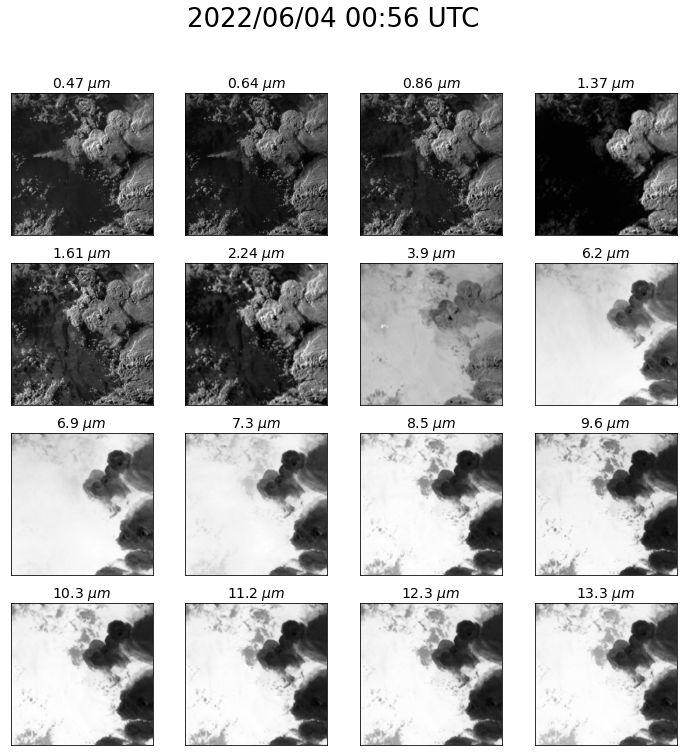

In [22]:
from plot_tifs import * # ./scripts/plot_tifs.py
# Plot all saved ABI bands for the current sample
plot_all_bands(fn_head)

### 4.3. Composites

Each ABI band highlights different atmospheric or surface features. By combining multiple bands, we can create composite images that enhance specific phenomena.  
For example, the near-IR "veggie" band (C03) provides strong contrast when interacting with healthy vegetation, making it useful for land surface analysis.


In [28]:
# Define composites
composites = ['airmass', 'true_color_raw', 'true_color','natural_color']
composites = ['cimss_true_color_sunz_rayleigh'] # define the true color composite

In [29]:
# Generate and save RGB composite imagery (e.g., True Color, Airmass) for a given lat/lon
def create_composite(sat_fns, lat, lon, composites=['cimss_true_color_sunz_rayleigh', 'airmass'], res=1000):
    # Create a filename header using the GOES timestamp and coordinates
    fn_head = 'G' + sat_fns[0].split('_G')[-1].split('_c')[0] + '_' + lat + '_' + lon

    # Calculate spatial extent (in meters) around the specified location
    extent = get_extent(lat, lon, res)

    # Load and resample the selected composite products into a Satpy Scene object
    scn = get_scn(sat_fns, composites, extent, res)

    # Generate and save each composite as a 3-channel RGB image
    for composite in composites:
        data = get_RGB(scn, composite)
        save_data(data, composite, fn_head)

    # Return the filename header and the Scene object for reference
    return fn_head, scn

# Create and save specified RGB composites for the region of interest
fn_head, scn = create_composite(sat_fns, lat, lon, composites)

saved file: ./data/data/cimss_true_color_sunz_rayleigh_G16_s20221550056176_e20221550058549_33_-106.tif


#### 4.3.1. Plot Composites

2022/06/04 00:56 UTC


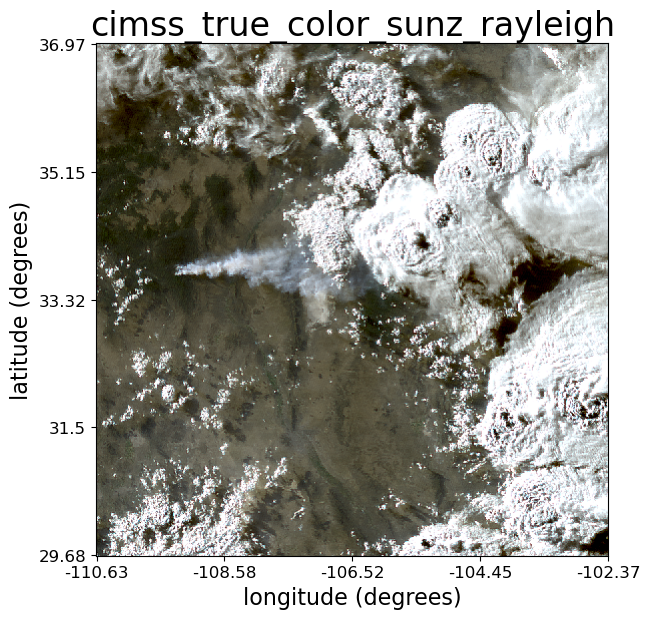

In [30]:
# Plot a saved composite image with labeled latitude and longitude axes
def plot_composite(composite, fn_head, data_loc="./data/"):
    # Locate the composite image file based on the filename header
    data_fn = glob(f"{data_loc}data/{composite}_{fn_head}*.tif")[0]

    # Locate the corresponding coordinate file (lat/lon)
    coords_fn = glob(f"{data_loc}coords/{fn_head}.tif")[0]

    # Print the datetime parsed from the coordinate filename
    print(get_datetime_from_fn(coords_fn))

    # Load the RGB image and coordinate arrays
    RGB = skimage.io.imread(data_fn, plugin='tifffile')
    lat, lon = get_lat_lon(coords_fn)

    # Plot the composite image with geolocated axes
    plt.figure(figsize=(8, 6), dpi=100)
    plt.imshow(RGB)

    # Set Y-axis ticks and labels using latitude values
    plt.yticks(np.linspace(0, RGB.shape[0] - 1, len(lat)), np.round(lat, 2), fontsize=12)
    plt.ylabel('latitude (degrees)', fontsize=16)

    # Set X-axis ticks and labels using longitude values
    plt.xticks(np.linspace(0, RGB.shape[1] - 1, len(lon)), np.round(lon, 2), fontsize=12)
    plt.xlabel('longitude (degrees)', fontsize=16)

    # Add a title and adjust layout
    plt.title(composite, fontsize=24)
    plt.tight_layout(pad=0)
    plt.show()

# Loop through each composite and plot it
for composite in composites:
    plot_composite(composite, fn_head)